In [2]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [3]:
"""Demonstrate the QG (quasi-geostrophic) model."""

import numpy as np
import scipy.ndimage.filters as filters
from matplotlib import pyplot as plt

from dapper.mods.QG import default_prms, nx, sample_filename, square
from dapper.tools.progressbar import progbar

In [4]:
def show(x0, psi=True, ax=None):
    # Whether to show psi (streamfun) or q (potential vorticity)
    def psi_or_q(x):
        return x if psi else compute_q(x)
    # Create fig if necessary
    if ax == None:
        fig, ax = plt.subplots()
    # Init ax
    im = ax.imshow(psi_or_q(square(x0)))
    if psi:
        im.set_clim(-30, 30)
    else:
        im.set_clim(-28e4, 25e4)

    # Define plot update fun, which we return
    def update(x):
        im.set_data(psi_or_q(square(x)))
    return update

# 
# Although psi is the state variable, q looks cooler.
# q = Nabla^2(psi) - F*psi.
dx = 1/(nx-1)


def compute_q(psi):
    Lapl = filters.laplace(psi, mode='constant')/dx**2
    # mode='constant' coz BCs are: psi = nabla psi = nabla^2 psi = 0
    return Lapl - default_prms['F']*psi

In [ ]:
# Assuming xx is your data array
xx = np.load(sample_filename)['sample']
xx = xx[0:-1:100]

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
for ax in (ax1, ax2):
    ax.set_aspect('equal', 'box')
ax1.set_title(r'$\psi$')
ax2.set_title('$q$')

setter1 = show(xx[0], psi=True, ax=ax1)
setter2 = show(xx[0], psi=False, ax=ax2)

# Update function for the animation
def update(frame):
    x = xx[frame]
    fig.suptitle(f"k: {frame}")
    setter1(x)
    setter2(x)

# Create the animation
ani = FuncAnimation(fig, update, frames=len(xx), interval=100)
file_path = '/home/sm_maran/simulation/animations/animation.mp4'

# Save the animation
ani.save(
    file_path,
    writer='ffmpeg',
    fps=20,                # Frames per second
    dpi=300,               # Dots per inch
    bitrate=2000,          # Bitrate in kbps
    codec='libx264',       # Codec
    extra_args=['-pix_fmt', 'yuv420p'] # Additional arguments if needed
)

# Fourier

In [ ]:
from scipy.fftpack import fft2, ifft2, fftshift

## 2D

In [152]:
def moving_average_2d_fft(time_series, window_size, stride):
    # Fourier transform along spatial dimensions for each time step
    fft_series = fftshift(fft2(time_series))
    times = []
    avg_fft = []
    
    t = 0
    while t + window_size < time_series.shape[0]:
        times.append(t)
        end_time = t + window_size
        avg_fft.append(np.average(np.abs(fft_series[t:end_time,:,:]),axis=0))
        t += stride
    return np.array(avg_fft), times

# Example usage
X_reshaped = np.array([square(x) for x in xx])
window_size = 1000
result, times = moving_average_2d_fft(X_reshaped[:,:,:], window_size, window_size)


In [180]:
global_min = np.inf
global_max = -np.inf

for i,res in enumerate(result):
    data = res
    global_min = min(global_min, np.min(data))
    global_max = max(global_max, np.max(data))

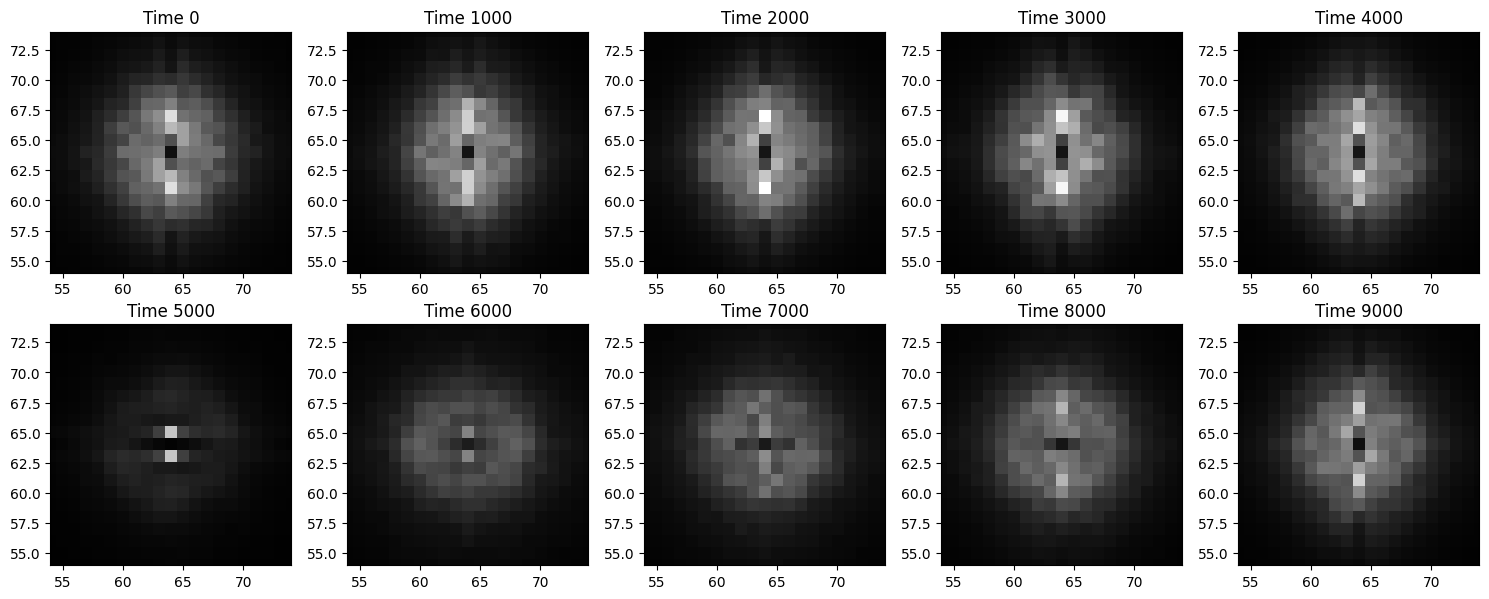

In [203]:
# Create a figure with subplots
yi, xi = 2,5
fig, axes = plt.subplots(yi, xi, figsize=(15, 6))  # Adjust the figsize as needed

delta = 10
# Loop over the first axis
for i, (res, t) in enumerate(zip(result, times)):
    row, col = i // xi, i % xi  # Determine the row and column for the subplot
    axes[row, col].imshow(res, cmap='gray', vmin=global_min, vmax=global_max)  # Plot the 2D slice
    axes[row, col].set_title(f'Time {t}')
    #axes[row, col].axis('off')
    axes[row, col].set_xlim([64-delta,64+delta])
    axes[row, col].set_ylim([64-delta,64+delta])

plt.tight_layout()
plt.show()


## Radial

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2
from scipy.ndimage import center_of_mass

# Assuming you already have your data and fft2 result
data = fft2(X_reshaped_cut[1000, :, :])

# Compute the center of mass as the center of the 2D Fourier transform
center_x, center_y = 64, 64

# Create an array of radii
max_radius = min(center_x, center_y)  # Maximum radius is limited by the center position
radii = np.arange(0, max_radius)

# Initialize an array to store the radial profile
radial_profile = []

# Iterate over the radii
for i, r in enumerate(radii):
    # Create a binary mask of the circle with radius r centered at the origin
    y, x = np.ogrid[-center_y:data.shape[0] - center_y, -center_x:data.shape[1] - center_x]
    mask = (x**2 + y**2 <= (r+1)**2) & (x**2 + y**2 >= r**2)
    # Calculate the average magnitude within the circle
    radial_profile.append(mask)

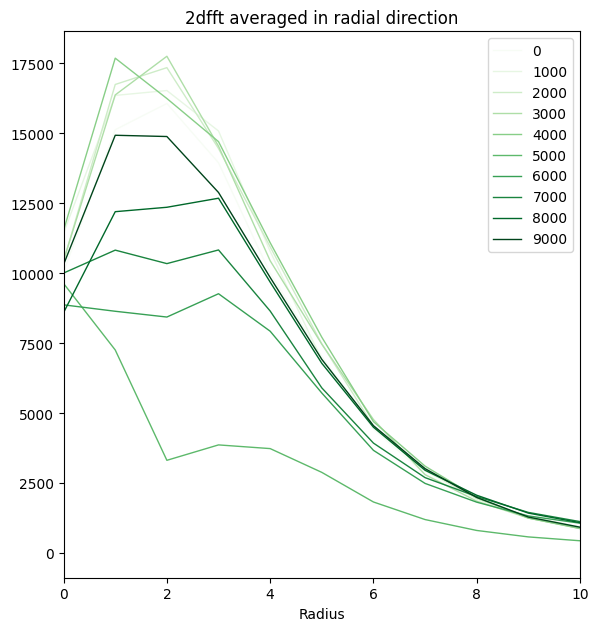

In [198]:
fig = plt.figure(figsize=(6,6))
from matplotlib.colors import LinearSegmentedColormap

colors = plt.cm.Greens(np.linspace(0, 1, len(result)))  # You can choose any colormap you like


# Loop over the first axis
for i, (res, t, color) in enumerate(zip(result, times, colors)):
    radial_res = np.array([np.mean(res[mask]) for mask in radial_profile])
    plt.plot(radii, radial_res, label=f'{t}', color=color, linewidth=1)

plt.legend()
plt.tight_layout()
plt.title("2dfft averaged in radial direction")
plt.xlim([0,10])
plt.xlabel("Radius")
plt.show()


TypeError: Invalid shape (129, 1, 129) for image data

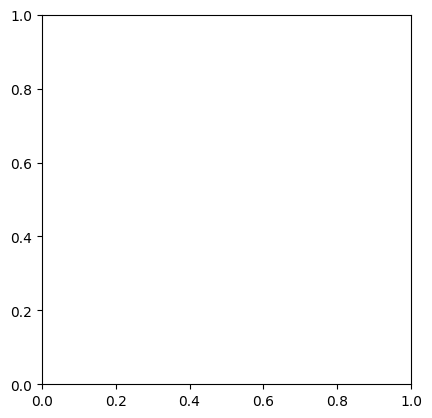

In [32]:
import matplotlib.pyplot as plt
import numpy as np


magnitude = np.abs(result[:, :, 0])
plt.imshow(magnitude, cmap='hot')
plt.title(f'Magnitude of Fourier Transform at Time Step {time_step}')
plt.colorbar()
plt.show()



# KNN

In [5]:
xx = np.load(sample_filename)['sample']

In [10]:
# conda activate mlx includes dapper - yes! but does it work with QG?

# sakov paper DA cycle dt=5 
# how long forecasts before chaos enters?
# 48 hrs if DA cycle is 3 hrs means dt=5*16
# so far used t+k with k=5 -> try k=15 

import numpy as np, scipy.signal

#from sklearnex import patch_sklearn
import sklearn
from sklearn.neighbors import KNeighborsRegressor
#patch_sklearn()

# # load high res data
# X_lp = np.load('/home/sm_tland/dpr_data/samples/QG_samples_7.npz')['sample'].astype('float32')
# # (10001, 16641)
# X_lp = np.array([scipy.signal.decimate(X_lp[i].reshape((2**7+1,2**7+1)),2,n=None,ftype='fir',axis=0) for i in range(X_lp.shape[0])])
# X_lp = np.array([scipy.signal.decimate(X_lp[i],2,n=None,ftype='fi§r',axis=1) for i in range(X_lp.shape[0])])
# X_lp = X_lp.reshape((X_lp.shape[0],np.prod(X_lp.shape[1:])))
# np.save('/home/sm_tland/dpr_data/samples/QG_samples_lp_7.npy', X_lp)
X_lp = np.load(sample_filename)['sample']

# load low res data
#X = np.load('/home/sm_tland/dpr_data/samples/QG_samples_6.npz')['sample'].astype('float32')
# (10001, 4225)
# X : {array-like, sparse matrix} of shape (n_samples, n_features)
n_ens = 100
knn = KNeighborsRegressor(n_neighbors=n_ens, weights='distance')

# do k step prediction
# fit using first n-k 
n = 8000
# k = 5
# k = 10
k = 12
# k = 15

reg_x = slice(0,n-k)
reg_y = slice(0+k,n-k+k)

# fit to X
#knn.fit(X[reg_x], X[reg_y])

# fit to X_lp
knn.fit(X_lp[reg_x], X_lp[reg_y])

# predict using 8001:10001-5
prd_x = slice(n,10001-k)
prd_y = slice(n+k,10001-k+k)

# predict X
#Yp = knn.predict(X[prd_x]).astype('float32')

# predict X_lp
Yp_lp = knn.predict(X_lp[prd_x]).astype('float32')
# (1996, 4225)
# np.save('/home/sm_tland/dpr_data/samples/knn_prd_x_lp_7.npy', Yp_lp)
# np.save('/home/sm_tland/dpr_data/samples/knn_prd_x_10_lp_7.npy', Yp_lp)
# np.save('/home/sm_tland/dpr_data/samples/knn_prd_x_15_lp_7.npy', Yp_lp)

# how get the ensemble?
# tmp = knn.kneighbors(X[prd_x], return_distance=False)
#dst, ix = knn.kneighbors(X[prd_x])
dst_lp, ix = knn.kneighbors(X_lp[prd_x])
# (2000, 10)

# predicted ensemble
# E = X[reg_y][ix]
# (2000, 10, 4225)

# check that weighted mean is Yp
# idst = 1/dst
# Em = np.sum(E*idst[:,:,np.newaxis], axis=1)/sum(idst, axis=1)[:,np.newaxis]

# norm(Em-Yp)
# 1.9075783207962807e-12

# https://journals.ametsoc.org/view/journals/hydr/15/4/jhm-d-14-0008_1.xml
# Why Should Ensemble Spread Match the RMSE of the Ensemble Mean?
# correct: square root of average ensemble variance 

# also checkout: https://www.ecmwf.int/sites/default/files/elibrary/2017/17626-ensemble-verification-metrics.pdf

# ens std
#e_std = np.mean(np.std(Yp[:,np.newaxis,:] - X[reg_y][ix], axis=1), axis=1)
#e_std = np.sqrt(np.mean(np.std(Yp[:,np.newaxis,:] - X[reg_y][ix], axis=1)**2, axis=1))
e_std_lp = np.sqrt(np.mean(np.std(Yp_lp[:,np.newaxis,:] - X_lp[reg_y][ix], axis=1)**2, axis=1))

# rms for ens mean
#e_rms = np.sqrt(np.mean((Yp - X[prd_y])**2, axis=1))
e_rms_lp = np.sqrt(np.mean((Yp_lp - X_lp[prd_y])**2, axis=1))
e_bias_lp = np.mean((Yp_lp - X_lp[prd_y]), axis=1)

# what if ens is all X - then Yp=mean 
# = std for clim
#e_std_clm = np.std(np.mean(X[prd_y], axis=0)[np.newaxis,:]-X[prd_y], axis=1)
e_std_clm_lp = np.std(np.mean(X_lp[prd_y], axis=0)[np.newaxis,:]-X_lp[prd_y], axis=1)

# rms clm
#e_rms_clm = np.sqrt(np.mean((np.mean(X[reg_x], axis=0)[np.newaxis,:] - X[prd_y])**2, axis=1))
e_rms_clm_lp = np.sqrt(np.mean((np.mean(X_lp[reg_x], axis=0)[np.newaxis,:] - X_lp[prd_y])**2, axis=1))

# np.savez('/home/sm_tland/dpr_data/samples/knn_5_lp_7.npy', e_std_clm_lp, e_rms_clm_lp, e_std_lp, e_rms_lp)
# np.savez('/home/sm_tland/dpr_data/samples/knn_10_lp_7.npy', e_std_clm_lp, e_rms_clm_lp, e_std_lp, e_rms_lp)
# np.savez('/home/sm_tland/dpr_data/samples/knn_12_lp_7.npy', e_std_clm_lp, e_rms_clm_lp, e_std_lp, e_rms_lp)
# np.savez('/home/sm_tland/dpr_data/samples/knn_15_lp_7.npy', e_std_clm_lp, e_rms_clm_lp, e_std_lp, e_rms_lp)


# train on X predict X

# clf()
# plot(e_rms)
# plot(e_std)
# plot(e_rms_clm)
# plot(e_std_clm)

# train on X_lp predict X_lp

clf()
plot(e_rms_lp)
plot(e_std_lp)
plot(e_rms_clm_lp)
plot(e_std_clm_lp)

from scipy.ndimage.filters import uniform_filter1d
N = 100
clf()
plot(uniform_filter1d(e_rms_lp, size=N))
plot(uniform_filter1d(e_std_lp, size=N))
plot(uniform_filter1d(e_rms_clm_lp, size=N))
plot(uniform_filter1d(e_std_clm_lp, size=N))
legend(('rmse','std','rmse clim','std clim'))


KeyboardInterrupt: 

In [ ]:
#
# stepping QG
#

# problem with dapper in env mlx? try dapper = WORKS!
# ModuleNotFoundError: No module named 'QG.f90.py_mod'

# conda activate dapper

# assume we start from here

cd /home/sm_tland/src/DAPPER/dapper/mods
import QG

X_lp = np.load('/home/sm_tland/dpr_data/samples/QG_samples_lp_7.npy').astype('float32')
# X_lp = np.load('/home/sm_tland/dpr_data/samples/QG_samples_lp_7.npy')[:10]
# X = np.load('/home/sm_tland/dpr_data/samples/QG_samples_6.npz')['sample'][:10]
# X generated with step model.prms["dtout"] and then subsampled with factor Spacing=10

model = QG.model_config("MY_step_model", {})
# Use `prms={}` to get the default configuration.
# mp=True means multiproc for ens
# *** try simulating ensemble of indep X0!!!
simulator = QG.modelling.with_recursion(model.step, prog=False)
# how turn of prog? prog=False should be default...

# k = 1 corresponds to DA cycle, say 3 hr so 48 hr forecast is k=15
# k = 5
# k = 10
k = 12
# k = 15

Spacing = 10
# sample = simulator(X[0], Spacing*k, 0.0, model.prms["dtout"])[::Spacing]
# now sample[i] = X[0+i], i=0,1,..,K

# with sample = simulator(X[0], K, 0.0, model.prms["dtout"])
# sample[0] is X0=X[0], sample[K] is X[1]?
# norm(sample[0]-X[0]) = 0 OK
# norm(sample[K]-X[1]) = 0 OK

n = 8000
# predict using 8001:10001-5
prd_x = slice(n,10001-k)
prd_y = slice(n+k,10001-k+k)

# prd_x = slice(n,10001-k) is index to X0
# sample = np.array([simulator(X0, Spacing*k, 0.0, model.prms["dtout"])[-1] for X0 in X_lp[prd_x]])

# in multiproc mode:
# OSError: /software/sse/easybuild/prefix/software/imkl/2018.1.163-iimpi-2018a/compiler/lib/intel64/libiomp5.so: cannot open shared object file: No such file or directory
# how was f90 built?
sample = simulator(X_lp[prd_x], Spacing*k, 0.0, model.prms["dtout"])[-1]
# np.save('/home/sm_tland/dpr_data/samples/QG_prd_x_lp_7.npy', sample)
# np.save('/home/sm_tland/dpr_data/samples/QG_prd_x_10_lp_7.npy', sample)
# np.save('/home/sm_tland/dpr_data/samples/QG_prd_x_12_lp_7.npy', sample)
# np.save('/home/sm_tland/dpr_data/samples/QG_prd_x_15_lp_7.npy', sample)

sample = np.load('/home/sm_tland/dpr_data/samples/QG_prd_x_lp_7.npy')
e_rms_qg_lp = np.sqrt(np.mean((sample - X_lp[prd_y])**2, axis=1))


clf()
plot(uniform_filter1d(e_rms_qg_lp, size=N))
plot(uniform_filter1d(e_rms_lp, size=N))
plot(uniform_filter1d(e_std_lp, size=N))
plot(uniform_filter1d(e_rms_clm_lp, size=N))
plot(uniform_filter1d(e_std_clm_lp, size=N))
legend(('rms qg','rms knn','std knn','rms clim','std clim'),ncol=5, fontsize=8)
ylim(3,10)
savefig('qg_example_errors.png')






from scipy.ndimage.filters import uniform_filter1d
N = 100
n = 8000

#
# 5
# 

k = 5
prd_y = slice(n+k,10001-k+k)
sample = np.load('/home/sm_tland/dpr_data/samples/QG_prd_x_lp_7.npy')
e_rms_qg_lp = np.sqrt(np.mean((sample - X_lp[prd_y])**2, axis=1))

buf = np.load('/home/sm_tland/dpr_data/samples/knn_5_lp_7.npy.npz')
e_std_clm_lp, e_rms_clm_lp, e_std_lp, e_rms_lp = buf['arr_0'],buf['arr_1'],buf['arr_2'],buf['arr_3']

clf()
plot(uniform_filter1d(e_rms_qg_lp, size=N),'g')
plot(uniform_filter1d(e_rms_lp, size=N),'b')
plot(uniform_filter1d(e_std_lp, size=N),'--b')
plot(uniform_filter1d(e_rms_clm_lp, size=N),'r')
plot(uniform_filter1d(e_std_clm_lp, size=N),'--r')
legend(('rms qg','rms knn','std knn','rms clim','std clim'),ncol=5, fontsize=8)
ylim(3,11)
title('5 step ahead prediction (100 time step running mean)')
savefig('qg_5_example_errors.png')

#
# 10
#

k = 10
prd_y = slice(n+k,10001-k+k)
sample = np.load('/home/sm_tland/dpr_data/samples/QG_prd_x_10_lp_7.npy')
e_rms_qg_lp = np.sqrt(np.mean((sample - X_lp[prd_y])**2, axis=1))

buf = np.load('/home/sm_tland/dpr_data/samples/knn_10_lp_7.npy.npz')
e_std_clm_lp, e_rms_clm_lp, e_std_lp, e_rms_lp = buf['arr_0'],buf['arr_1'],buf['arr_2'],buf['arr_3']

clf()
plot(uniform_filter1d(e_rms_qg_lp, size=N),'g')
plot(uniform_filter1d(e_rms_lp, size=N),'b')
plot(uniform_filter1d(e_std_lp, size=N),'--b')
plot(uniform_filter1d(e_rms_clm_lp, size=N),'r')
plot(uniform_filter1d(e_std_clm_lp, size=N),'--r')
legend(('rms qg','rms knn','std knn','rms clim','std clim'),ncol=5, fontsize=8)
ylim(3,11)
title('10 step ahead prediction (100 time step running mean)')
savefig('qg_10_example_errors.png')

#
# 12
#

k = 12
prd_y = slice(n+k,10001-k+k)
sample = np.load('/home/sm_tland/dpr_data/samples/QG_prd_x_12_lp_7.npy')
e_rms_qg_lp = np.sqrt(np.mean((sample - X_lp[prd_y])**2, axis=1))

buf = np.load('/home/sm_tland/dpr_data/samples/knn_12_lp_7.npy.npz')
e_std_clm_lp, e_rms_clm_lp, e_std_lp, e_rms_lp = buf['arr_0'],buf['arr_1'],buf['arr_2'],buf['arr_3']

clf()
plot(uniform_filter1d(e_rms_qg_lp, size=N),'g')
plot(uniform_filter1d(e_rms_lp, size=N),'b')
plot(uniform_filter1d(e_std_lp, size=N),'--b')
plot(uniform_filter1d(e_rms_clm_lp, size=N),'r')
plot(uniform_filter1d(e_std_clm_lp, size=N),'--r')
legend(('rms qg','rms knn','std knn','rms clim','std clim'),ncol=5, fontsize=8)
ylim(3,11)
title('12 step ahead prediction (100 time step running mean)')
savefig('qg_12_example_errors.png')

#
# 15
#

k = 15
prd_y = slice(n+k,10001-k+k)
sample = np.load('/home/sm_tland/dpr_data/samples/QG_prd_x_15_lp_7.npy')
e_rms_qg_lp = np.sqrt(np.mean((sample - X_lp[prd_y])**2, axis=1))

buf = np.load('/home/sm_tland/dpr_data/samples/knn_15_lp_7.npy.npz')
e_std_clm_lp, e_rms_clm_lp, e_std_lp, e_rms_lp = buf['arr_0'],buf['arr_1'],buf['arr_2'],buf['arr_3']

clf()
plot(uniform_filter1d(e_rms_qg_lp, size=N),'g')
plot(uniform_filter1d(e_rms_lp, size=N),'b')
plot(uniform_filter1d(e_std_lp, size=N),'--b')
plot(uniform_filter1d(e_rms_clm_lp, size=N),'r')
plot(uniform_filter1d(e_std_clm_lp, size=N),'--r')
legend(('rms qg','rms knn','std knn','rms clim','std clim'),ncol=5, fontsize=8)
ylim(3,11)
title('15 step ahead prediction (100 time step running mean)')
savefig('qg_15_example_errors.png')
